# 学習

In [1]:
# ライブラリ読み込み
import glob
import cv2
import numpy as np
import os

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import albumentations as albu
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
train_dir = 'train'
val_dir = 'val'

In [3]:
# データ確認用
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
# データ拡張
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [5]:
# テンソル化
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# 前処理
def get_preprocessing(preprocessing_fn):
    _transform = [
            albu.Lambda(image=preprocessing_fn),
            albu.Lambda(image=to_tensor, mask=to_tensor),
        ]
    return albu.Compose(_transform)

In [6]:
# データセット
class Dataset(BaseDataset):
    CLASSES = ['background', 'dog']
    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [classes.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # mask
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [7]:
# モデルを宣言
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['dog']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
DECODER = 'deeplab'
model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
model = model.to("cuda")

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [8]:
# データセットを作成
train_dataset = Dataset(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'masks'),
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['dog'],
)
valid_dataset = Dataset(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'masks'),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['dog'],
)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

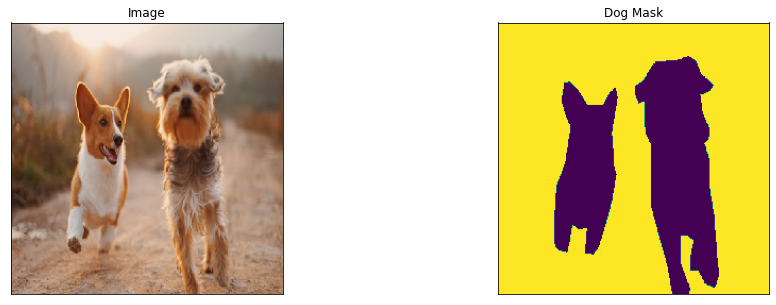

In [9]:
# データ確認
dataset = Dataset(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'masks'), classes=['dog'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    dog_mask=mask.squeeze(),
)

In [10]:
# 精度確認指標
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
# ロス
loss = smp.utils.losses.DiceLoss()
# 最適化関数
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

In [11]:
# 1Epochトレイン用
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [12]:
# 学習 40EPoch 25Epochで学習率を下げる
max_score = 0
for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    try:
        train_logs = train_epoch.run(train_loader)
        val_logs = valid_epoch.run(valid_loader)
    except Exception as e:
        print(e)

    # do something (save model, change lr, etc.)
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, f'{DECODER}_{ENCODER}.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')


Epoch: 0
valid: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 36.90it/s, dice_loss - 0.5032, iou_score - 0.3429]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 37.59it/s, dice_loss - 0.2365, iou_score - 0.6676]
Model saved!

Epoch: 2
valid: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 36.99it/s, dice_loss - 0.1858, iou_score - 0.7281]
Model saved!

Epoch: 3
valid: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 37.09it/s, dice_loss - 0.1164, iou_score - 0.8142]
Model saved!

Epoch: 4
valid: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 37.10it/s, dice_loss - 0.1317, iou_score - 0.7819]

Epoch: 5
valid: 100%|███████████████████████████████████| 14/14 [00:00<00:00, 37.03it/s, dice_loss - 0.1532, iou_score - 0.7494]

Epoch: 6
valid: 100%|██████████████████████████████████| 14/14 [00:00<00:00, 35.87it/s, dice_loss - 0.06698, iou_score - 0.8835]
Model saved!

Epoch: 7
valid: 100%|███

# 確認
テスト用のデータを持ってきて試してもよいですが、valのデータを使います。

In [21]:
# 画像読み込み
val_files = glob.glob('val/images/*')
f = val_files[5]
image_src = cv2.imread(f)
image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

# 前処理
image = preprocessing_fn(image_src)
image = image.transpose(2, 0, 1).astype('float32')

# モデルで推論
image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
predict = model(image)
predict = predict.detach().cpu().numpy()[0].reshape((256,256))

# 0.5以上を1とする
predict_img = np.zeros([256,256]).astype(np.int8)
predict_img = np.where(predict>0.5, 1 , predict_img)

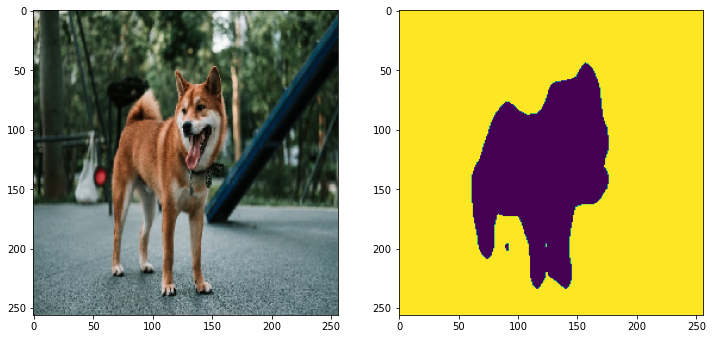

In [22]:
# 横並び
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(image_src)
ax2.imshow(predict_img)